# Leaf tracking, in a time-series of 3D segmented maize plants

Corresponding article in Plant Methods (Daviet et al. 2022) : https://doi.org/10.1186/s13007-022-00961-4)

3D segmentations were obtained with Phenomenal (https://github.com/openalea/phenomenal)

In this notebook, 3D visualisations are made with matplotlib. Other tools could be used for more advanced visualisations such as openalea.plantgl (https://github.com/openalea/plantgl)

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import openalea.phenomenal.object.voxelSegmentation as phm_seg

from openalea.phenomenal.tracking.trackedPlant import TrackedPlant
from openalea.phenomenal.tracking.display import PALETTE
from openalea.phenomenal.tracking.phenomenal_coupling import phm_to_phenotrack_input
from openalea.phenomenal.tracking.polyline_utils import polyline_length

from openalea.phenotyping_data.fetch import fetch_all_data

In [2]:
def plot3d(polylines, ranks):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")
    plt.axis("off")
    for pl, rank in zip(polylines, ranks):
        color = (
            PALETTE[int(rank - 1)] / 255.0
            if rank > 0
            else np.array([80, 80, 80]) / 255.0
        )
        linestyle = "-" if rank > 0 else "--"
        ax.plot(
            pl[:, 0],
            pl[:, 1],
            zs=pl[:, 2],
            color=color,
            linewidth=0.7,
            linestyle=linestyle,
        )

## 1 - Data Preparation

### Load a time-series of segmented plant (from Phenomenal)

In [4]:
datadir = fetch_all_data("3d_time_series")

In [6]:
phm_segs, timestamps = [], []
for filename in sorted(os.listdir(datadir)):
    timestamps.append(int(filename.split(".gz")[0]))
    phm_segs.append(
        phm_seg.VoxelSegmentation.read_from_json_gz(os.path.join(datadir, filename))
    )

### Remove time-steps with an abnormal stem shape, and conversion to a generic format

In [7]:
phenotrack_segs, checks_stem = phm_to_phenotrack_input(phm_segs, timestamps)

print(
    f"{len(phm_segs) - len(phenotrack_segs)} time-step was removed due to an abnormal stem shape"
)

1 time-step was removed due to an abnormal stem shape


### Display all time-steps in a same window
+ Each segmented leaf is represented by a 3D polyline (grey dotted line = unknown leaf rank)

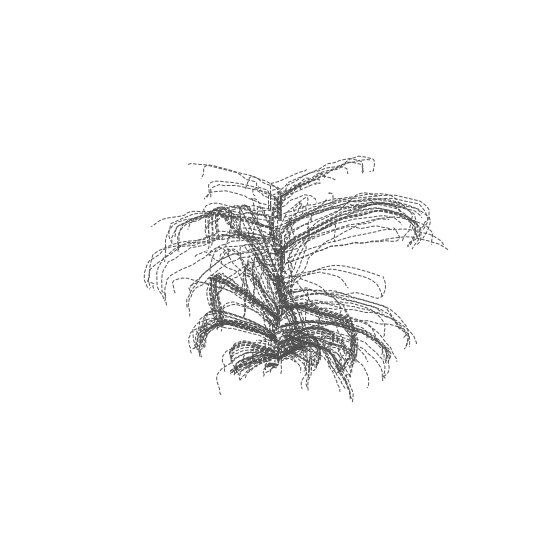

In [8]:
polylines = [pl for seg in phenotrack_segs for pl in seg["polylines_sequence"]]
plot3d(polylines, [-1] * len(polylines))

### Initialize the TrackedPlant object

In [9]:
trackedplant = TrackedPlant.load(phenotrack_segs)

## 2 - Tracking of mature leaves

### Display the initial topological ordering
+ At each time step, mature leaves are ordered in a sequence, by increasing insertion height (i.e. using topology). This gives a first estimation of leaf ranks, ordered from the bottom to the top of the stem.
+ The 3D plot below illustrates these leaf ranks (red = 1, green = 2, dark blue = 3, ...). It can be seen that this approach is not consistent over time. This is because some leaves are disappearinig at the bottom of the plant over time, which shifts the measured ranks of the remaining leaves. The goal of mature leaves tracking is to fix this.

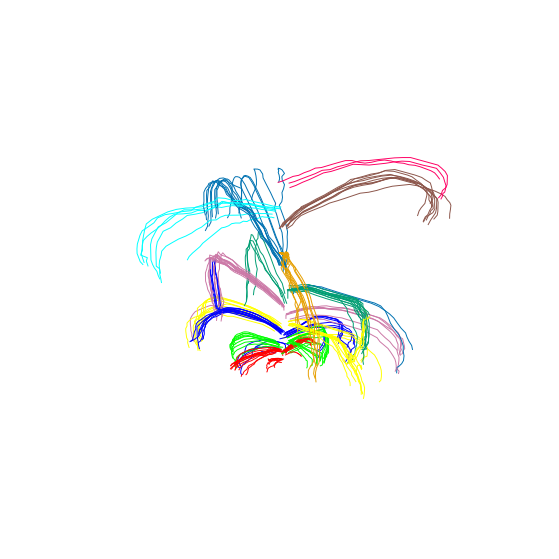

In [10]:
raw_ranks = [
    r + 1
    for s in trackedplant.snapshots
    for r, l in enumerate(s.leaves)
    if l.features["mature"]
]
polylines = [
    l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features["mature"]
]
plot3d(polylines, raw_ranks)

### Sequence alignment of mature leaves
+ Use sequence alignment to match mature leaves that have similar morphology features in different time-steps.

In [11]:
# tracking with the parameters from the original publication
trackedplant.mature_leaf_tracking(
    start=0,  # which time step is used to initialize tracking
    gap=12,  # gap penalty parameter
    w_h=0.03,  # importance weight for leaf height feature
    w_l=0.004,  # importance weight for leaf length feature
    gap_extremity_factor=0.2,  # weight applied to the gap penalty on sequence extremities
    align_range=None,  # maximum distance between two time-steps so that thet can be compared (inf if None)
)

### Display the new leaf ranks

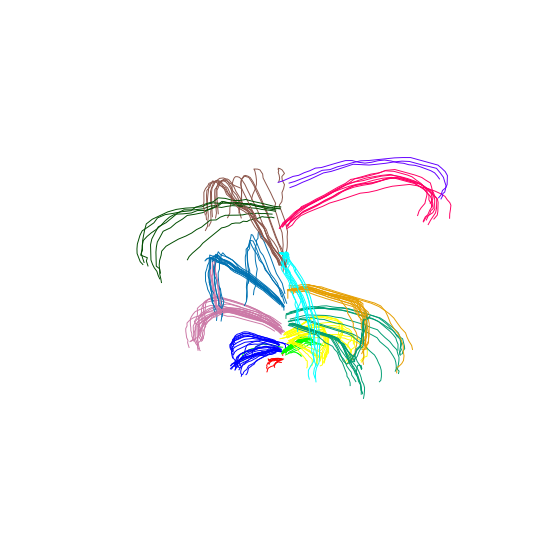

In [12]:
ranks = [
    r
    for s in trackedplant.snapshots
    for l, r in zip(s.leaves, s.leaf_ranks())
    if l.features["mature"]
]
polylines = [
    l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features["mature"]
]
plot3d(polylines, ranks)

### Note: Sequence alignment is sensible to the parameters used
+ It might be important to finetune the parameters for new experiments. 
+ an example of another set of parameters that might work well : trackedplant.mature_leaf_tracking(start=20, gap=2.5, w_h=0.03, w_l=0.004, gap_extremity_factor=0.8, align_range=None)

## 3 - Tracking of growing leaves

### Run tracking

In [13]:
trackedplant.growing_leaf_tracking()

### Display it
+ The output of growing leaf tracking is more difficult to visualise all at once.
+ Also, dealing with growing leaves is more difficult in general; there are more errors than for mature leaf tracking

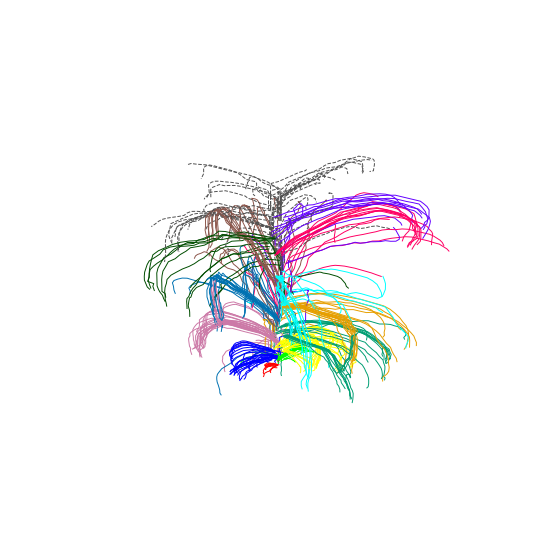

In [14]:
ranks = [r for s in trackedplant.snapshots for l, r in zip(s.leaves, s.leaf_ranks())]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves]
plot3d(polylines, ranks)

## 4. Extracting traits (with the example of leaf lengths)

### Create a dataframe with the rank and length of each leaf

In [15]:
df = []
for snapshot, time in zip(trackedplant.snapshots, np.array(timestamps)[checks_stem]):
    for rank, leaf in zip(snapshot.leaf_ranks(), snapshot.leaves):
        length = polyline_length(leaf.polyline)
        df.append([time, rank, length, leaf.features["mature"]])
df = pd.DataFrame(df, columns=["time", "rank", "length", "mature"])
df["time"] = (df["time"] - np.min(df["time"])) / 3600 / 24

### Display the leaf length function of rank
+ Only mature leaf tracking is necessary here !

Text(0, 0.5, 'Mature leaf length (mm)')

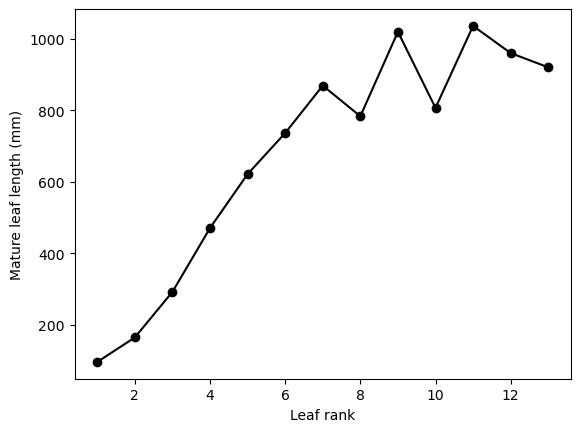

In [16]:
t_max = (
    20  # time after leaf emergence when a mature leaf is not considered anymore (days)
)

ranks = sorted([r for r in df["rank"].unique() if r > 0])
lengths = []
for rank in ranks:
    s = df[(df["rank"] == rank) & (df["mature"])]
    s = s[s["time"] < np.min(s["time"]) + t_max]
    lengths.append(np.median(s["length"]))

plt.figure()
plt.plot(ranks, lengths, "k-o")
plt.xlabel("Leaf rank")
plt.ylabel("Mature leaf length (mm)")

### Display the growth dynamics of one leaf over time
+ Here, growing leaf tracking is necessary. Results are generally more noisy, since growing leaf tracking makes more errors, and only one length measure is available at each time step (whereas for the previous trait, it was possible to average several measures for each leaf rank).

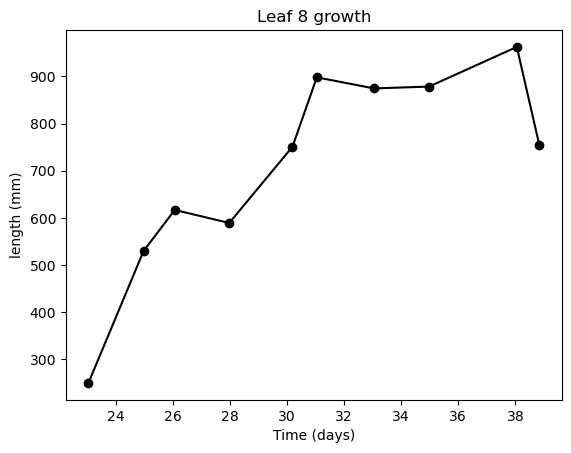

In [17]:
rank = 8

s = df[(df["rank"] == rank) & (~df["mature"])].sort_values("time")

plt.figure()
plt.title("Leaf 8 growth")
plt.xlabel("Time (days)")
plt.ylabel("length (mm)")
plt.plot(s["time"], s["length"], "k-o")